In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Read the words from the file
def read_words(filename):
    with open(filename, 'r') as f:
        words = [line.strip() for line in f.readlines()]
    return words

# Load the words
words = read_words('brown_nouns.txt')
print(f"Total words: {len(words)}")
print(f"First 10 words: {words[:10]}")

Total words: 202793
First 10 words: ['investigation', 'primary', 'election', 'evidence', 'irregularities', 'place', 'jury', 'presentments', 'charge', 'election']


In [3]:
class TrieNode:
    def __init__(self):
        self.children = defaultdict(TrieNode)
        self.is_end = False
        self.frequency = 0
        self.depth = 0
        
    def __str__(self):
        return f"TrieNode(children={list(self.children.keys())}, is_end={self.is_end}, frequency={self.frequency})"

In [1]:
class PrefixTrie:
    def __init__(self):
        self.root = TrieNode()
        self.root.frequency = 0
        
    def insert(self, word):
        node = self.root
        for char in word:
            node = node.children[char]
            node.frequency += 1
        node.is_end = True
        
    def search(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                return False
            node = node.children[char]
        return node.is_end
    
    def find_stem(self, word):
        node = self.root
        stem = []
        max_branching_index = 0
        max_branching_value = 0
        
        for i, char in enumerate(word):
            if char not in node.children:
                break
                
            node = node.children[char]
            branching_factor = len(node.children)
            
            # Check if this node has higher branching
            if branching_factor > max_branching_value:
                max_branching_value = branching_factor
                max_branching_index = i + 1  # index where we should split
                
            stem.append(char)
            
        # If we found a branching point, split there
        if max_branching_index > 0:
            stem = word[:max_branching_index]
            suffix = word[max_branching_index:]
        else:
            stem = word
            suffix = ""
            
        return stem, suffix

In [4]:
class SuffixTrie:
    def __init__(self):
        self.root = TrieNode()
        self.root.frequency = 0
        
    def insert(self, word):
        # Reverse the word for suffix trie
        reversed_word = word[::-1]
        node = self.root
        for char in reversed_word:
            node = node.children[char]
            node.frequency += 1
        node.is_end = True
    
    def find_stem(self, word):
        # Reverse the word to process from the end
        reversed_word = word[::-1]
        node = self.root
        suffix = []
        max_branching_index = 0
        max_branching_value = 0
        
        for i, char in enumerate(reversed_word):
            if char not in node.children:
                break
                
            node = node.children[char]
            branching_factor = len(node.children)
            
            # Check if this node has higher branching
            if branching_factor > max_branching_value:
                max_branching_value = branching_factor
                max_branching_index = i + 1  # index where we should split
                
            suffix.append(char)
            
        # If we found a branching point, split there
        if max_branching_index > 0:
            # The suffix is the part we've traversed (in reverse order)
            suffix = ''.join(suffix[:max_branching_index])[::-1]
            stem = word[:-max_branching_index]
        else:
            stem = word
            suffix = ""
            
        return stem, suffix

In [5]:
# Build prefix trie
prefix_trie = PrefixTrie()
for word in words:
    prefix_trie.insert(word)

# Build suffix trie
suffix_trie = SuffixTrie()
for word in words:
    suffix_trie.insert(word)

# Test on some examples
test_words = ['goes', 'kites', 'running', 'happily', 'boxes', 'children']
print("Prefix Trie Results:")
for word in test_words:
    stem, suffix = prefix_trie.find_stem(word)
    print(f"{word}={stem}+{suffix}")

print("\nSuffix Trie Results:")
for word in test_words:
    stem, suffix = suffix_trie.find_stem(word)
    print(f"{word}={stem}+{suffix}")

Prefix Trie Results:
goes=g+oes
kites=k+ites
running=ru+nning
happily=ha+ppily
boxes=bo+xes
children=c+hildren

Suffix Trie Results:
goes=goe+s
kites=kite+s
running=runn+ing
happily=happil+y
boxes=boxe+s
children=childr+en


Same stemming result: 3.68%
Average prefix stem length: 1.59
Average suffix stem length: 5.29


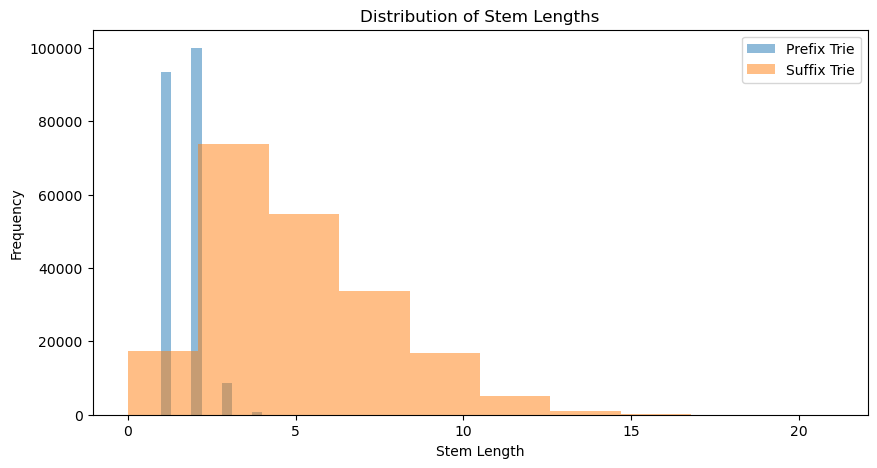

In [6]:
def evaluate_trie(trie, words, trie_type="prefix"):
    results = []
    for word in words:
        if trie_type == "prefix":
            stem, suffix = trie.find_stem(word)
        else:
            stem, suffix = trie.find_stem(word)
        results.append((word, stem, suffix))
    return results

# Evaluate both tries
prefix_results = evaluate_trie(prefix_trie, words, "prefix")
suffix_results = evaluate_trie(suffix_trie, words, "suffix")

# Compare the results
def analyze_results(prefix_results, suffix_results):
    prefix_stem_lengths = []
    suffix_stem_lengths = []
    same_result = 0
    
    for i, (word, p_stem, p_suffix) in enumerate(prefix_results):
        s_stem, s_suffix = suffix_results[i][1], suffix_results[i][2]
        prefix_stem_lengths.append(len(p_stem))
        suffix_stem_lengths.append(len(s_stem))
        
        if p_stem == s_stem and p_suffix == s_suffix:
            same_result += 1
    
    print(f"Same stemming result: {same_result/len(prefix_results)*100:.2f}%")
    print(f"Average prefix stem length: {np.mean(prefix_stem_lengths):.2f}")
    print(f"Average suffix stem length: {np.mean(suffix_stem_lengths):.2f}")
    
    # Plot the distribution of stem lengths
    plt.figure(figsize=(10, 5))
    plt.hist(prefix_stem_lengths, alpha=0.5, label='Prefix Trie')
    plt.hist(suffix_stem_lengths, alpha=0.5, label='Suffix Trie')
    plt.xlabel('Stem Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Stem Lengths')
    plt.legend()
    plt.show()

analyze_results(prefix_results, suffix_results)

In [7]:
# Show some examples of differences
print("Examples where prefix and suffix tries differ:")
count = 0
for i, (word, p_stem, p_suffix) in enumerate(prefix_results):
    s_stem, s_suffix = suffix_results[i][1], suffix_results[i][2]
    if p_stem != s_stem or p_suffix != s_suffix:
        print(f"Word: {word}")
        print(f"  Prefix: {p_stem} + {p_suffix}")
        print(f"  Suffix: {s_stem} + {s_suffix}")
        print()
        count += 1
    if count >= 10:  # Show only 10 examples
        break

Examples where prefix and suffix tries differ:
Word: investigation
  Prefix: in + vestigation
  Suffix: investigati + on

Word: primary
  Prefix: p + rimary
  Suffix: primar + y

Word: election
  Prefix: e + lection
  Suffix: electi + on

Word: evidence
  Prefix: e + vidence
  Suffix: evidenc + e

Word: irregularities
  Prefix: i + rregularities
  Suffix: irregularitie + s

Word: place
  Prefix: p + lace
  Suffix: plac + e

Word: jury
  Prefix: ju + ry
  Suffix: jur + y

Word: presentments
  Prefix: p + resentments
  Suffix: presentment + s

Word: charge
  Prefix: c + harge
  Suffix: charg + e

Word: election
  Prefix: e + lection
  Suffix: electi + on



In [8]:
# Save the results to a file
with open('stemming_results.txt', 'w') as f:
    f.write("Word,Prefix_Stem,Prefix_Suffix,Suffix_Stem,Suffix_Suffix\n")
    for i, (word, p_stem, p_suffix) in enumerate(prefix_results):
        s_stem, s_suffix = suffix_results[i][1], suffix_results[i][2]
        f.write(f"{word},{p_stem},{p_suffix},{s_stem},{s_suffix}\n")

print("Results saved to stemming_results.txt")

Results saved to stemming_results.txt
